## Food Classification Using CNNs

Team member: Jimmy Vu, Eric Zhao

### Data Source
- Food-101 Dataset Page: https://paperswithcode.com/dataset/food-101
- Food-101 Dataset Package: http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
import os
import pandas as pd
import math
import cv2

In [ ]:
# Get available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPUs available:", gpus)

# Check if GPU memory is accessible
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print(f"GPU {gpu.name} details:", details)


GPUs available: []


### Load Data

In [ ]:
# food pictures
data_directory = 'food-101/images/'

class_file = 'food-101/meta/classes.txt'
# dataset already split
train_file = 'food-101/meta/train.txt'
test_file = 'food-101/meta/test.txt'


Found 101000 images belonging to 101 classes.


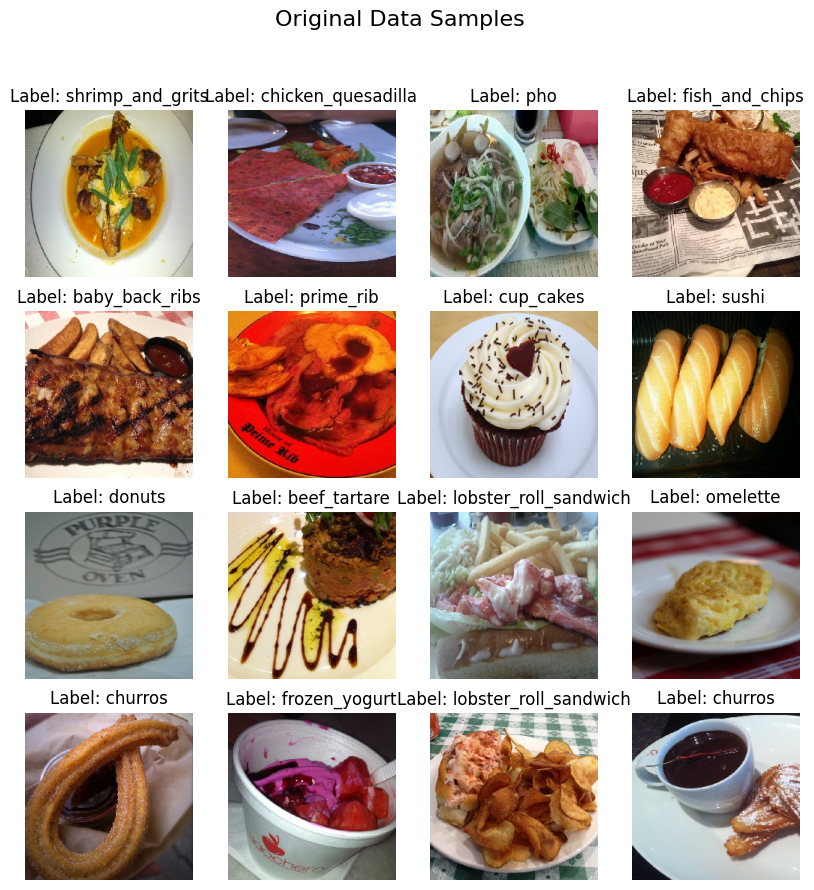

In [ ]:
# Create a data generator that only rescales pixel values.
original_datagen = ImageDataGenerator(rescale=1./255)

# Flow images from the directory.
original_generator = original_datagen.flow_from_directory(
    directory=data_directory,
    target_size=(224, 224), # EfficientNetB0 expects 224x224 images by default
    batch_size=16,
    class_mode='categorical',
    shuffle=True # Images are randomly selected from the dataset
)

# Get a single batch of images and labels.
orig_images, orig_labels = next(original_generator)

subplot_number_v, subplot_number_h = 4, 4
sample_image = subplot_number_v * subplot_number_h

# Plot a 4x4 grid of 16 sample images.
plt.figure(figsize=(10, 10))
for i in range(sample_image):
    plt.subplot(subplot_number_v, subplot_number_h, i + 1)
    plt.imshow(orig_images[i])
    # Get the class names from the generator's dictionary.
    class_idx = np.argmax(orig_labels[i])
    class_names = list(original_generator.class_indices.keys())
    plt.title(f"Label: {class_names[class_idx]}")
    plt.axis('off')
plt.suptitle("Original Data Samples", fontsize=16)
plt.show()

In [ ]:
# Read and filter test samples
records = []
with open(test_file, 'r') as f:
    for line in f:
        rel_path = line.strip()
        if not rel_path:
            continue
        class_name = rel_path.split('/')[0]
        if class_name not in class_names:
            continue
        abs_path = os.path.join(data_directory, rel_path + '.jpg')
        records.append({'filename': abs_path, 'class': class_name})

test_df = pd.DataFrame(records)

# Create generator from dataframe
test_data = ImageDataGenerator(rescale=1./255)

test_generator = test_data.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    classes=class_names,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

steps = math.ceil(test_generator.samples / test_generator.batch_size)


Found 25250 validated image filenames belonging to 101 classes.


In [ ]:
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
    )

In [ ]:
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(101, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name}")

Layer 0: input_layer
Layer 1: rescaling
Layer 2: normalization
Layer 3: rescaling_1
Layer 4: stem_conv_pad
Layer 5: stem_conv
Layer 6: stem_bn
Layer 7: stem_activation
Layer 8: block1a_dwconv
Layer 9: block1a_bn
Layer 10: block1a_activation
Layer 11: block1a_se_squeeze
Layer 12: block1a_se_reshape
Layer 13: block1a_se_reduce
Layer 14: block1a_se_expand
Layer 15: block1a_se_excite
Layer 16: block1a_project_conv
Layer 17: block1a_project_bn
Layer 18: block2a_expand_conv
Layer 19: block2a_expand_bn
Layer 20: block2a_expand_activation
Layer 21: block2a_dwconv_pad
Layer 22: block2a_dwconv
Layer 23: block2a_bn
Layer 24: block2a_activation
Layer 25: block2a_se_squeeze
Layer 26: block2a_se_reshape
Layer 27: block2a_se_reduce
Layer 28: block2a_se_expand
Layer 29: block2a_se_excite
Layer 30: block2a_project_conv
Layer 31: block2a_project_bn
Layer 32: block2b_expand_conv
Layer 33: block2b_expand_bn
Layer 34: block2b_expand_activation
Layer 35: block2b_dwconv
Layer 36: block2b_bn
Layer 37: block2b

In [ ]:
print("Samples:", test_generator.samples)
print("Batch size:", test_generator.batch_size)
print("Steps:", steps)

Samples: 25250
Batch size: 32
Steps: 790


In [ ]:
# Evaluate
test_generator.reset()
loss, accuracy = model.evaluate(test_generator, steps=steps)

# Predict
test_generator.reset()
predictions = model.predict(test_generator, steps=steps)
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_generator.labels

# Compute F1
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Test Accuracy:\t{accuracy:.4f}')
print(f'Test Loss:\t{loss:.4f}')
print(f'Test F1 Score:\t{f1:.4f}')


790/790 ━━━━━━━━━━━━━━━━━━━━ 340s 430ms/step - accuracy: 0.0018 - loss: 4.6407
790/790 ━━━━━━━━━━━━━━━━━━━━ 334s 423ms/step
Test Accuracy:	0.0099
Test Loss:	4.6542
Test F1 Score:	0.0002


pre-trained model(EfficientNetB0) accuracy is 0.99%, the model need training.

In [ ]:
# imagedatagenerator process images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


# function load images
# Function to create train and val generators
def create_generators(datagen, directory, samples_file):
    records = []
    with open(samples_file, 'r') as f:
        for line in f:
            rel_path = line.strip()
            if not rel_path:
                continue
            class_name = rel_path.split("/")[0]
            if class_name not in class_names:
                continue
            abs_path = os.path.join(directory, rel_path + '.jpg')
            records.append({'filename': abs_path, 'class': class_name})

    df = pd.DataFrame(records)
    train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['class'], random_state=42)

    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        classes=class_names,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = test_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        classes=class_names,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator


# Function to create test generator
def create_test_generator(datagen, directory, samples_file):
    records = []
    with open(samples_file, 'r') as f:
        for line in f:
            rel_path = line.strip()
            if not rel_path:
                continue
            class_name = rel_path.split("/")[0]
            if class_name not in class_names:
                continue
            abs_path = os.path.join(directory, rel_path + '.jpg')
            records.append({'filename': abs_path, 'class': class_name})

    df = pd.DataFrame(records)
    test_generator = datagen.flow_from_dataframe(
        dataframe=df,
        x_col='filename',
        y_col='class',
        classes=class_names,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )
    return test_generator


# Create generators
train_generator, val_generator = create_generators(train_datagen, data_directory, train_file)
test_generator = create_test_generator(test_datagen, data_directory, test_file)

Found 68175 validated image filenames belonging to 101 classes.
Found 7575 validated image filenames belonging to 101 classes.
Found 25250 validated image filenames belonging to 101 classes.


MAKE SURE THE IMAGES ADD UP TO THE CORRECT AMOUNT 101000

In [ ]:
# Model setup
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(101, activation='softmax')
])

In [ ]:
# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# model is the module that contains the functions to build and manage the complete models
# base_model refers to pre-trained models available in Keras that are often used as feature extractors (EfficientNetB0). These models are typically loaded without the top classification layers (include_top=False), so we can add our own layers on top.
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}")

Layer 0: efficientnetb0
Layer 1: global_average_pooling2d_2
Layer 2: dense_3
Layer 3: dropout_1
Layer 4: dense_4


In [ ]:
train_log1 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

c:\Users\Jimmy\Desktop\CS171 Project\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1437s 671ms/step - accuracy: 0.2998 - loss: 2.9650 - val_accuracy: 0.5850 - val_loss: 1.6069
Epoch 2/10
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1447s 679ms/step - accuracy: 0.4787 - loss: 2.0531 - val_accuracy: 0.6096 - val_loss: 1.5046
Epoch 3/10
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1409s 661ms/step - accuracy: 0.5109 - loss: 1.9141 - val_accuracy: 0.6280 - val_loss: 1.4590
Epoch 4/10
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1396s 655ms/step - accuracy: 0.5243 - loss: 1.8393 - val_accuracy: 0.6294 - val_loss: 1.4334
Epoch 5/10
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1266s 594ms/step - accuracy: 0.5347 - loss: 1.7987 - val_accuracy: 0.6362 - val_loss: 1.4192
Epoch 6/10
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1234s 579ms/step - accuracy: 0.5443 - loss: 1.7565 - val_accuracy: 0.6380 - val_loss: 1.4201
Epoch 7/10
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1225s 575ms/step - accuracy: 0.5470 - loss: 1.7414 - val_accuracy: 0.6451 - val_loss: 1.3909
Epoch 8/10
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1208s 567ms/s

In [ ]:
# Evaluate
test_generator.reset()
loss, accuracy = model.evaluate(test_generator, steps=steps)

# Predict
test_generator.reset()
predictions = model.predict(test_generator, steps=steps)
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_generator.labels

# Compute F1
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Test Accuracy:\t{accuracy:.4f}')
print(f'Test Loss:\t{loss:.4f}')
print(f'Test F1 Score:\t{f1:.4f}')

790/790 ━━━━━━━━━━━━━━━━━━━━ 290s 368ms/step - accuracy: 0.6716 - loss: 1.2088
790/790 ━━━━━━━━━━━━━━━━━━━━ 291s 366ms/step
Test Accuracy:	0.6959
Test Loss:	1.1141
Test F1 Score:	0.6936


### save progress

In [ ]:
model.save('food101_efficientnetB0.keras')

### Result
Test Accuracy: 69.59% (updated)

### Fine tune in progress

In [ ]:
model = tf.keras.models.load_model('food101_efficientnetB0.h5')

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,403,466 (16.80 MB)

 Trainable params: 353,893 (1.35 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
base_model = model.layers[0]
base_model.trainable = True

for layer in base_model.layers[:-5]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
train_log2 = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

c:\Users\Jimmy\Desktop\CS171 Project\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1205s 562ms/step - accuracy: 0.4702 - loss: 2.2490 - val_accuracy: 0.6173 - val_loss: 1.5282
Epoch 2/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1243s 583ms/step - accuracy: 0.5280 - loss: 1.8444 - val_accuracy: 0.6313 - val_loss: 1.4551
Epoch 3/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1332s 625ms/step - accuracy: 0.5502 - loss: 1.7458 - val_accuracy: 0.6387 - val_loss: 1.4288
Epoch 4/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1302s 611ms/step - accuracy: 0.5715 - loss: 1.6599 - val_accuracy: 0.6527 - val_loss: 1.3889
Epoch 5/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1249s 586ms/step - accuracy: 0.5825 - loss: 1.5937 - val_accuracy: 0.6582 - val_loss: 1.3605


In [ ]:
# Evaluate
test_generator.reset()
loss, accuracy = model.evaluate(test_generator, steps=steps)

# Predict
test_generator.reset()
predictions = model.predict(test_generator, steps=steps)
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_generator.labels

# Compute F1
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Test Accuracy:\t{accuracy:.4f}')
print(f'Test Loss:\t{loss:.4f}')
print(f'Test F1 Score:\t{f1:.4f}')

790/790 ━━━━━━━━━━━━━━━━━━━━ 299s 378ms/step - accuracy: 0.6778 - loss: 1.1675
790/790 ━━━━━━━━━━━━━━━━━━━━ 288s 363ms/step
Test Accuracy:	0.7022
Test Loss:	1.0835
Test F1 Score:	0.7008


test accuracy: 0.7370 -> 0.7022 (updated)

In [ ]:
model.save('food101_efficientnetB0_finetune5.keras', save_format='keras')

### try fine tune last 10

In [ ]:
model10 = tf.keras.models.load_model('food101_efficientnetB0_finetune5.keras')

In [ ]:
base_model10 = model10.layers[0]
base_model10.trainable = True

for layer in base_model10.layers[:-10]:
    layer.trainable = False

model10.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
train_log2 = model10.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1387s 647ms/step - accuracy: 0.6178 - loss: 1.4463 - val_accuracy: 0.6863 - val_loss: 1.2546
Epoch 2/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1325s 622ms/step - accuracy: 0.6339 - loss: 1.3788 - val_accuracy: 0.6908 - val_loss: 1.2298
Epoch 3/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1273s 597ms/step - accuracy: 0.6433 - loss: 1.3254 - val_accuracy: 0.6920 - val_loss: 1.2223
Epoch 4/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1244s 583ms/step - accuracy: 0.6501 - loss: 1.2932 - val_accuracy: 0.6952 - val_loss: 1.2073
Epoch 5/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1256s 589ms/step - accuracy: 0.6600 - loss: 1.2574 - val_accuracy: 0.7024 - val_loss: 1.2042


In [ ]:
# Evaluate
test_generator.reset()
loss, accuracy = model10.evaluate(test_generator, steps=steps)

# Predict
test_generator.reset()
predictions = model10.predict(test_generator, steps=steps)
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_generator.labels

# Compute F1
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Test Accuracy:\t{accuracy:.4f}')
print(f'Test Loss:\t{loss:.4f}')
print(f'Test F1 Score:\t{f1:.4f}')

790/790 ━━━━━━━━━━━━━━━━━━━━ 306s 387ms/step - accuracy: 0.7258 - loss: 0.9986
790/790 ━━━━━━━━━━━━━━━━━━━━ 324s 408ms/step
Test Accuracy:	0.7472
Test Loss:	0.9136
Test F1 Score:	0.7462


test accuracy: 0.7910 (improved) -> 0.7472 (updated)

In [ ]:
model10.save('food101_efficientnetB0_finetune10.keras', save_format='keras')

### try unfreeze last 15

In [ ]:
model15 = tf.keras.models.load_model('food101_efficientnetB0_finetune10.keras')

In [ ]:
base_model15 = model15.layers[0]
base_model15.trainable = True

for layer in base_model15.layers[:-15]:
    layer.trainable = False

model15.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
train_log3 = model15.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1196s 561ms/step - accuracy: 0.6649 - loss: 1.2369 - val_accuracy: 0.7011 - val_loss: 1.1987
Epoch 2/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1523s 715ms/step - accuracy: 0.6694 - loss: 1.2114 - val_accuracy: 0.7052 - val_loss: 1.1746
Epoch 3/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1538s 722ms/step - accuracy: 0.6726 - loss: 1.1971 - val_accuracy: 0.7073 - val_loss: 1.1839
Epoch 4/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1507s 707ms/step - accuracy: 0.6803 - loss: 1.1739 - val_accuracy: 0.7080 - val_loss: 1.1692
Epoch 5/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1357s 637ms/step - accuracy: 0.6901 - loss: 1.1375 - val_accuracy: 0.7112 - val_loss: 1.1648


In [ ]:
# Evaluate
test_generator.reset()
loss, accuracy = model15.evaluate(test_generator, steps=steps)

# Predict
test_generator.reset()
predictions = model15.predict(test_generator, steps=steps)
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_generator.labels

# Compute F1
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Test Accuracy:\t{accuracy:.4f}')
print(f'Test Loss:\t{loss:.4f}')
print(f'Test F1 Score:\t{f1:.4f}')

790/790 ━━━━━━━━━━━━━━━━━━━━ 296s 375ms/step - accuracy: 0.7319 - loss: 0.9634
790/790 ━━━━━━━━━━━━━━━━━━━━ 309s 390ms/step
Test Accuracy:	0.7548
Test Loss:	0.8832
Test F1 Score:	0.7542


In [ ]:
model15.save('food101_efficientnetB0_finetune15_updated.keras', save_format='keras')

### Result
Test Accuracy: 81.15% -> 75.48% (updated)

### try unfreeze last 20


In [ ]:
model20 = tf.keras.models.load_model('food101_efficientnetB0_finetune15_updated.keras')

In [ ]:
base_model20 = model20.layers[0]
base_model20.trainable = True

for layer in base_model20.layers[:-20]:
    layer.trainable = False

model20.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
train_log4 = model20.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)

Epoch 1/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1228s 573ms/step - accuracy: 0.6871 - loss: 1.1374 - val_accuracy: 0.7121 - val_loss: 1.1696
Epoch 2/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1295s 608ms/step - accuracy: 0.6981 - loss: 1.0925 - val_accuracy: 0.7098 - val_loss: 1.1730
Epoch 3/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1227s 576ms/step - accuracy: 0.6925 - loss: 1.1100 - val_accuracy: 0.7125 - val_loss: 1.1651
Epoch 4/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1194s 560ms/step - accuracy: 0.6970 - loss: 1.0903 - val_accuracy: 0.7137 - val_loss: 1.1551
Epoch 5/5
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 1269s 596ms/step - accuracy: 0.7012 - loss: 1.0726 - val_accuracy: 0.7123 - val_loss: 1.1564


In [ ]:
# Evaluate
test_generator.reset()
loss, accuracy = model20.evaluate(test_generator, steps=steps)

# Predict
test_generator.reset()
predictions = model20.predict(test_generator, steps=steps)
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_generator.labels

# Compute F1
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Test Accuracy:\t{accuracy:.4f}')
print(f'Test Loss:\t{loss:.4f}')
print(f'Test F1 Score:\t{f1:.4f}')

790/790 ━━━━━━━━━━━━━━━━━━━━ 330s 417ms/step - accuracy: 0.7462 - loss: 0.9268
790/790 ━━━━━━━━━━━━━━━━━━━━ 330s 415ms/step
Test Accuracy:	0.7606
Test Loss:	0.8675
Test F1 Score:	0.7596


In [ ]:
model20.save('food101_efficientnetB0_finetune20_updated.keras', save_format='keras')

### Result
Test Accuracy: 76.06% (updated)

## Reference
<div style="padding-left: 2em; text-indent: -2em;">
Huilgol, P. (2025, March 10). Top 4 Pre-Trained Models for Image Classification with Python Code. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/
</div>

